## Predicting Precipitation Type (Classifier)

#### *By: Heaton Chan, Rana Ghadymimahani, Amitaditya Paul, and Renee Choquette*

### Introduction:

One of the aspects that have a great impact on our day-to-day lives, yet that humans have very little control over, is the weather. Accurately predicting future weather has been a constant pursuit for many years, especially with the implications of global warming, which has been causing erratic changes to the climate. We believe that computer analysis is one of the most promising methods to achieve accurate weather predictions. In our project, we will be exploring a weather dataset to answer the following question: given the weather data in the United States, what type of precipitation (rain or snow) will occur. The original dataset contains weather data from different countries in the year 2020, but we chose to focus only on data from the United States (see Exploring Data for reasoning) and the following predictors: dew point, daily high temperature and daily low temperature. 

### Methods:

First, we loaded the packages needed to perform our analysis.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(tidyr)
library(gridExtra)
library(rvest)
library(stringr)
library(infer)
library(knitr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

#### Read Data:
Then we loaded and read our data from a remote source.

In [7]:
url = "https://raw.githubusercontent.com/codingonapotato/dsci100_group_project_S2022/main/data/daily_weather_2020.csv"
download_weather <- download.file(url, destfile = "daily_weather_2020.csv")  # Object used to summon the file from the internet to the local machine

weather_data_raw <- suppressWarnings(read_csv("daily_weather_2020.csv")) %>%
                        select(-X1) %>% #Gets rid of the column keeping track of column numbers
                        rename("Country" = "Country/Region")
head(weather_data_raw)

Parsed with column specification:
cols(
  .default = col_double(),
  `Country/Region` = col_character(),
  `Province/State` = col_character(),
  time = col_date(format = ""),
  summary = col_character(),
  icon = col_character(),
  precipType = col_character()
)

See spec(...) for full column specifications.



Country,Province/State,time,summary,icon,sunriseTime,sunsetTime,moonPhase,precipIntensity,precipIntensityMax,⋯,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,Lat,Long,precipAccumulation
<chr>,<chr>,<date>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afghanistan,NA,2019-12-31,"Rain (with a chance of 1–3 in. of snow) until night, starting again in the afternoon.",rain,1577846640,1577882700,0.20,0.0156,0.1515,⋯,1577827140,48.36,1577864700,30.51,1577835720,47.86,1577864700,33,65,NA
Afghanistan,NA,2020-01-01,Light rain throughout the day.,rain,1577933040,1577969160,0.23,0.0235,0.0985,⋯,1577918820,40.42,1577951460,29.84,1577919420,40.08,1577951220,33,65,NA
Afghanistan,NA,2020-01-02,Clear throughout the day.,rain,1578019440,1578055560,0.26,0.0016,0.0062,⋯,1578020400,46.53,1578038340,26.27,1578020400,46.03,1578038340,33,65,NA
Afghanistan,NA,2020-01-03,Partly cloudy throughout the day.,partly-cloudy-day,1578105900,1578142020,0.30,0.0003,0.0012,⋯,1578106320,45.77,1578124500,26.96,1578093240,45.35,1578124260,33,65,NA
Afghanistan,NA,2020-01-04,Light rain throughout the day.,rain,1578192300,1578228480,0.33,0.0145,0.0310,⋯,1578193080,40.84,1578222000,33.33,1578193080,40.34,1578222000,33,65,NA
Afghanistan,NA,2020-01-05,Light rain until afternoon.,rain,1578278700,1578314940,0.36,0.0196,0.0442,⋯,1578335400,44.54,1578297660,32.83,1578335400,44.07,1578297360,33,65,NA


#### Exploring Data

We first explored our data by finding all of the columns in the dataframe and then determine how many rows belong to each country. From `count` we discovered that the US had the greatest amount of data in the dataset and will likely allow us to produce a more accurate classifier, thus we decided to filter our data to only contain data from the US.

In [8]:
names <- colnames(weather_data_raw) # So that we can see all the column names in the dataframe

count <- weather_data_raw %>%
            group_by(Country) %>%
            summarize(number_of_rows = n()) %>%
            arrange(desc(number_of_rows)) 
            #glimpse()    # !!! <Ask Nour if glimpse or non glimpse ver. matters for readability>    
            # So that we can see the rows of data we have to work with in each region  

weather_data_US_only <- weather_data_raw %>%
            select(Country, precipProbability, temperatureHigh, temperatureLow, dewPoint, precipType) %>%
            filter(Country == "US") # dataframe that only contains data from US  
head(weather_data_US_only)

`summarise()` ungrouping output (override with `.groups` argument)



Country,precipProbability,temperatureHigh,temperatureLow,dewPoint,precipType
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
US,0.04,60.37,32.53,32.58,rain
US,0.07,61.00,47.42,30.54,rain
US,0.96,68.09,61.20,54.40,rain
US,0.98,63.40,54.90,61.56,rain
US,0.37,59.38,30.98,43.43,rain
US,0.06,60.45,35.99,30.59,rain


#### Dropping `NA`'s and Final Tidy Data

We then wanted to explore how many of the rows in our data are blank (listed as `NA`) and filter these rows out to produce our final tidy dataset (`weather_data`). We also included a table which summarizes the number of rows with all US data (including those with `NA`'s), how many of those rows contained missing values, and how many rows remain in the final tidy dataset. In addition, we wanted to see whether or not our data is balanced in terms of the proportion of rain vs. snow precipTypes. We saw that the ratio of rain to snow datapoints were about 70:30, thus we knew that we would need to balance our training data prior to building our classification model.

In [10]:
na_count <- weather_data_US_only %>%
                filter(is.na(precipProbability) 
                       | is.na(temperatureHigh) 
                       | is.na(temperatureLow) 
                       | is.na(dewPoint) 
                       | is.na(precipType)) %>%
                nrow() # To show the amount of missing data in our variables

weather_data <- weather_data_US_only %>% 
    drop_na() %>%
    mutate(precipType = as.factor(precipType)) #dropping all NA values from the dataset and mutating precipType into a factor
head(weather_data)

unified_tibble <- slice(count, 1) %>%
                    mutate(number_of_missing_values = na_count) %>%
                    mutate(number_of_rows_final = nrow(weather_data))
unified_tibble #Aggregate table for column number and number of *previously missing values in the dataset that got removed

class_count <- weather_data %>%
                select(precipType) %>%
                count(precipType) %>%
                mutate(proportion = n/nrow(weather_data))
class_count # Formally show the amount of each label we have in our tidy dataset



Country,precipProbability,temperatureHigh,temperatureLow,dewPoint,precipType
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
US,0.04,60.37,32.53,32.58,rain
US,0.07,61.00,47.42,30.54,rain
US,0.96,68.09,61.20,54.40,rain
US,0.98,63.40,54.90,61.56,rain
US,0.37,59.38,30.98,43.43,rain
US,0.06,60.45,35.99,30.59,rain


Country,number_of_rows,number_of_missing_values,number_of_rows_final
<chr>,<int>,<int>,<int>
US,6272,26,6246


precipType,n,proportion
<fct>,<int>,<dbl>
rain,4344,0.6954851
snow,1902,0.3045149


#### Splitting Data & Upsampling

We then split our original dataset into a training set (70% of original data) and a testing set (other 30% of original data). In addition, we upsampled our training data to produce a balanced dataset (`weather_train_upsampled`) for training our model.

In [11]:
set.seed(2022)

weather_split <- weather_data %>%
                initial_split(prop = 0.7, strata = precipType)

weather_training <- training(weather_split) #training dataset

weather_testing <- testing(weather_split) #testing dataset

data_proportions <-  tibble(proportion_of_total_in_training = (nrow(weather_training)/nrow(weather_data))) %>%
                        mutate(proportion_of_total_in_testing = (nrow(weather_testing)/nrow(weather_data)))
data_proportions # To formally show the percentage of the tidy dataset that went into the training and testing datasets

weather_upsampling_recipe <- recipe(precipType ~ dewPoint + temperatureLow + temperatureHigh + precipProbability, data = weather_training) %>%
    step_upsample(precipType, over_ratio = 1, skip = FALSE) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 

weather_train_upsampled <- weather_upsampling_recipe %>% 
                            prep() %>% 
                            bake(weather_training)

class_count_upsampled <- weather_train_upsampled %>%
                            select(precipType) %>%
                            count(precipType) %>%
                            mutate(proportion = n/nrow(weather_train_upsampled))
class_count_upsampled # Formally shows whether labels got upsampled successfully (looks like a yes to me!)

proportion_of_total_in_training,proportion_of_total_in_testing
<dbl>,<dbl>
0.7001281,0.2998719


Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


precipType,n,proportion
<fct>,<int>,<dbl>
rain,3041,0.5
snow,3041,0.5


#### Choosing and Visualizing Predictors

We then explored our data by calculating the mean dew point, probability of precipitation, daily high temperature, and daily low temperature.  In addition, we plotted our 3 predictors vs. probability of precipitation to visualize our data. From these visualizations, which all show a clear split between snow and rain precipitation types, we concluded that `dewPoint`, `temperatureHigh`, and `temperatureLow` have an effect on precipitation type. To confirm our choice of predictors, we also conducted some research which concluded that **ADD SOURCES HERE FOR WHY WE PICKED WHAT PREDICTOR**

n,mean_dewPoint,mean_temperatureLow,mean_temperatureHigh,mean_precipProbability
<int>,<dbl>,<dbl>,<dbl>,<dbl>
6082,3.585246e-17,1.110147e-16,-4.193833e-17,-2.528323e-17


TableGrob (2 x 2) "arrange": 3 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (1-1,2-2) arrange gtable[layout]
3 3 (2-2,1-1) arrange gtable[layout]

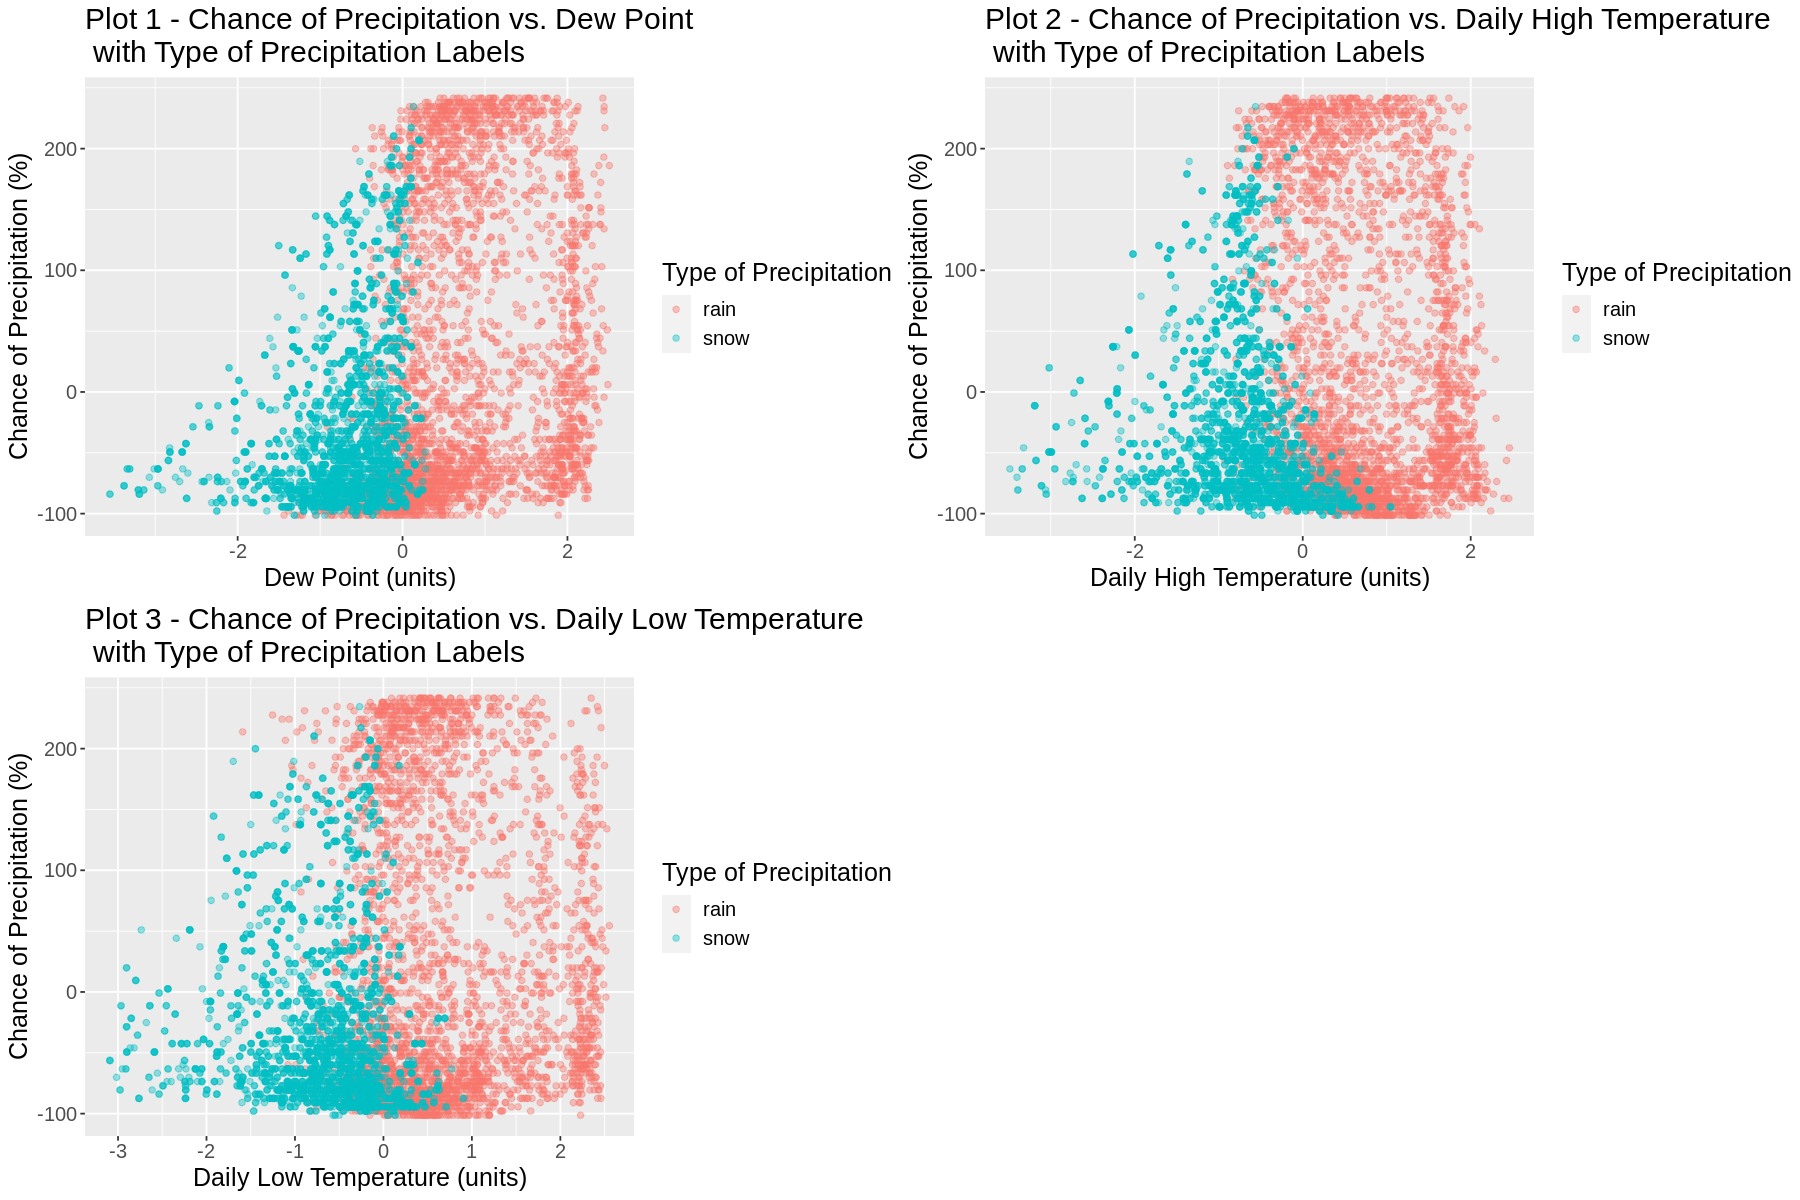

In [12]:
weather_train_means <- weather_train_upsampled %>%
                            select(-precipType) %>%
                            map_df(mean) %>%
                            rename(mean_dewPoint = dewPoint,
                                  mean_precipProbability = precipProbability,
                                  mean_temperatureHigh = temperatureHigh,
                                  mean_temperatureLow = temperatureLow) #computed means for across all columns

weather_train_total <- tibble(n = nrow(weather_train_upsampled)) #total number of rows for training data

weather_train_aggregate <- weather_train_total %>%
                                bind_cols(weather_train_means) #aggregated summary tables for the training data 
weather_train_aggregate

# possibly use the means as a MEANS (haha) to justify scaling the data? (i mean other than the fact that its standard practice for k-nn)

options(repr.plot.width = 15, repr.plot.height = 10)
plot1 <- weather_train_upsampled %>%
                        mutate(precipProbability = precipProbability*100) %>%
                        ggplot(aes(x = dewPoint, y = precipProbability)) +
                        geom_point(aes(colour = precipType), alpha = 0.4) +
                        labs(x = "Dew Point (units)", y = "Chance of Precipitation (%)", colour = "Type of Precipitation") +
                        theme(text = element_text(size = 15)) +
                        ggtitle("Plot 1 - Chance of Precipitation vs. Dew Point \n with Type of Precipitation Labels")

plot2 <- weather_train_upsampled %>%
                        mutate(precipProbability = precipProbability*100) %>%
                        ggplot(aes(x = temperatureHigh, y = precipProbability)) +
                        geom_point(aes(colour = precipType), alpha = 0.4) +
                        labs(x = "Daily High Temperature (units)", y = "Chance of Precipitation (%)", colour = "Type of Precipitation") +
                        theme(text = element_text(size = 15)) +
                        ggtitle("Plot 2 - Chance of Precipitation vs. Daily High Temperature \n with Type of Precipitation Labels")
plot3 <- weather_train_upsampled %>%
                        mutate(precipProbability = precipProbability*100) %>%
                        ggplot(aes(x = temperatureLow, y = precipProbability)) +
                        geom_point(aes(colour = precipType), alpha = 0.4) +
                        labs(x = "Daily Low Temperature (units)", y = "Chance of Precipitation (%)", colour = "Type of Precipitation") +
                        theme(text = element_text(size = 15)) +
                        ggtitle("Plot 3 - Chance of Precipitation vs. Daily Low Temperature \n with Type of Precipitation Labels")

plots_together <- grid.arrange(plot1, plot2, plot3, ncol = 2)
plots_together

#### Taking a Smaller Sample & Finding the Best K-value

Given that our training data contained over 6,000 rows, we were advised to take a small random stratified sample of our training data to then conduct a cross-validation analysis and find the best K-value for our K-NN model. When tuning, we first tested k-values in the range (1:100) (`k_vals`) and then were able to narrow down the range to (50:75) (`k_vals_narrowed`). We finally obtained a best K-value of 60.

precipType,n,proportion
<fct>,<int>,<dbl>
rain,250,0.5
snow,250,0.5


[1] 60

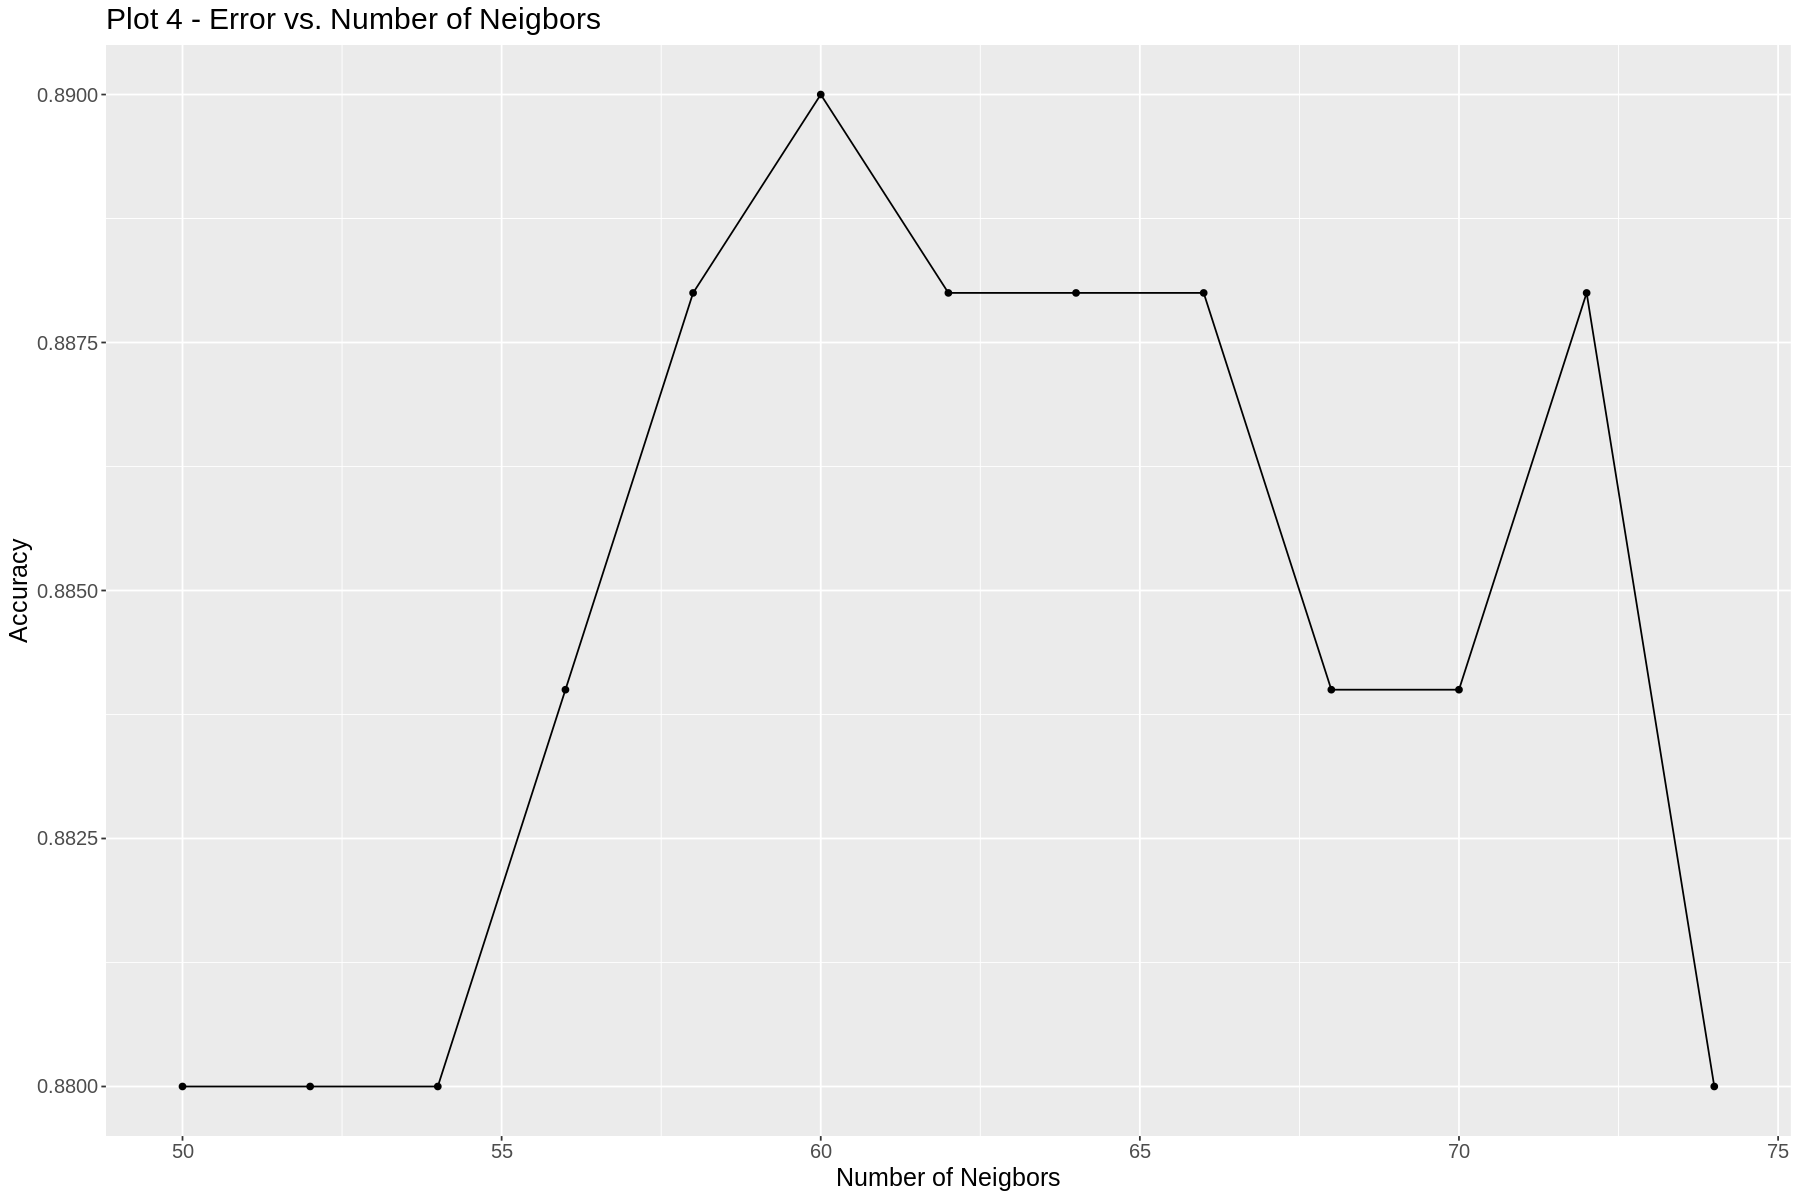

In [16]:
#---------------> DONT RUN THIS CELL CAUSE IT TAKES ALMOST A MINUTE TO RUN <--------------------
set.seed(2022)

weather_train_sample <- weather_train_upsampled %>%
    group_by(precipType) %>%
    sample_n(size = 250)

class_count_sample <- weather_train_sample %>%
                            select(precipType) %>%
                            count(precipType) %>%
                            mutate(proportion = n/nrow(weather_train_sample))
class_count_sample # Formally shows whether labels in random sample are balanced or not (balanced!)

weather_recipe <- recipe(precipType ~ dewPoint + temperatureLow + temperatureHigh, data = weather_train_sample) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification')

weather_vfold <- vfold_cv(weather_train_sample, v = 5, strata = precipType) 

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 10))
k_vals_narrowed <- tibble(neighbors = seq(from = 50, to = 75, by = 2))

number_of_neighbors_stats <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = weather_vfold, grid = k_vals_narrowed) %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

options(repr.plot.width = 15, repr.plot.height = 10)
number_of_neighbors_plot <- ggplot(number_of_neighbors_stats, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neigbors", y = "Accuracy",
        title = "Plot 4 - Accuracy vs. Number of Neigbors") +
    theme(text = element_text(size = 15))

number_of_neighbors_plot

best_k_value <- number_of_neighbors_stats %>%
    arrange(by = desc(mean)) %>%
    slice(1) %>%
    select(neighbors) %>%
    pull()
best_k_value

#### Training the Classifier & Accuracy Calculation

We then applied our K-NN model to the entire training data with the best K-value (60 neighbors) and calculated that our classifier performed with 92.0% accuracy on the training data. **uh i don't have any further comments to make about this accuracy value, but will use it to compare with the testing data accuracy for sure**

In [17]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_value) %>%
    set_engine('kknn') %>%
    set_mode('classification')

knn_fit <- workflow() %>%
    add_recipe(weather_recipe) %>%
    add_model(knn_spec) %>%
    fit(data = weather_training)

weather_accuracy <- predict(knn_fit, weather_training) %>%
    bind_cols(weather_training) %>%
    metrics(truth = precipType, estimate = .pred_class) %>%
    filter(.metric == "accuracy") %>%
    select(.estimate) %>%
    pull()
weather_accuracy

[1] 0.9199634

#### Applying Our Classifier to Testing Data

In [31]:
weather_predictions <- predict(knn_fit, weather_testing) %>%
                bind_cols(weather_testing)
tail(weather_predictions)

.pred_class,Country,precipProbability,temperatureHigh,temperatureLow,dewPoint,precipType
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
snow,US,0.19,43.27,31.79,24.30,snow
rain,US,0.12,49.78,31.66,25.81,rain
rain,US,0.05,53.16,32.36,22.48,rain
snow,US,0.66,16.58,1.97,7.20,snow
snow,US,0.43,16.80,6.34,0.14,snow
rain,US,0.06,50.95,30.06,19.98,snow


### Results

Our classifier obtained an accuracy of about 91.3%, which (as expected) is slightly lower than the accuracy obtained after running our classifier on the training data. We then obtained a confusion matrix of our data and summarized the results in a table (`weather_conf_stats`).


In [29]:
weather_predictions_accuracy <- weather_predictions %>%
                metrics(truth = precipType, estimate = .pred_class) %>%
                filter(.metric == "accuracy") %>%
                select(.estimate) %>%
                pull()
weather_predictions_accuracy

weather_confusion_matrix <- weather_predictions %>%
                conf_mat(truth = precipType, estimate = .pred_class) 
weather_confusion_matrix

# Values obtained from confusion matrix...
true_rain <- 1233 # Number of data points correctly classified as "rain"
true_snow <- 477 # Number of data points correctly classified as "snow"
false_rain <- 93 # Number of data points incorrectly classified as "rain"
false_snow <- 70 # Number of data points incorrectly classified as "snow"

weather_conf_stats <- weather_predictions %>%
                select(precipType) %>%
                count(precipType) %>%
                mutate(correct = c(true_rain, true_snow),
                       incorrect = c(false_rain, false_snow),
                       prop_correct = correct/n,
                       prop_incorrect = incorrect/n,
                       overall_accuracy = weather_predictions_accuracy)
weather_conf_stats

[1] 0.9129738

          Truth
Prediction rain snow
      rain 1233   93
      snow   70  477

precipType,n,correct,incorrect,prop_correct,prop_incorrect,overall_accuracy
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rain,1303,1233,93,0.9462778,0.07137375,0.9129738
snow,570,477,70,0.8368421,0.12280702,0.9129738


#### Visualization of Results

ok im leaving this for Heaton cause he told me to be a good teammate LOL :)

One of the ideas for visualizing our results that I wanted to try was to visualize the proportion of rain data that was classified correctly vs incorrectly and the proportion of snow data that was classified correctly vs incorrectly (which is why I created the weather_conf_stats table above) because interestingly the classifier is having more trouble classifiying snow than rain. Maybe that's just because the proportion of snow in the data is less so its underrepresented but maybe its because there is even another predictor that our data doesn't have that can help us get more accurate results (if we can find literature to support that another predictor like wind or smth also has an impact thatd be cool). Anyways, I think this could be interesting to discuss!

In [2]:
# code cells for visualization of results


### Discussion of Results

...

### Methods (COPIED FROM PROPOSAL):

Our goal is to predict what type of precipitation (rain or snow) will occur based on the following variables; dew point, daily high temperature, daily low temperature, humidity, pressure, and probability of precipitation, with a focus on the US region. We chose the above variables because our exploratory data analysis plots showed a clear split between snow and rain precipitation types when plotted, thus we believe that they all have an effect on the type of precipitation. We will do this by splitting our original dataset into a training set (75% of original data) and a testing set (25% of original). We will then use the training data set to train our classifier to predict the type of precipitation using a K-nearest neighbor model. Prior to building our model, we will perform a cross-fold analysis to obtain a K-value with the highest accuracy. Next, we will run our classifier on our testing set and measure how accurately it performed. Finally, we will use those results to graph the proportion of data points our classifier predicted correctly and incorrectly. We will use a bar plot to produce such a visualization, as bar plots are preferred when visualizing proportions in data. We may also graph scatter plots of our different predictors to visualize trends in our data. Furthermore, we have provided an example of a precipitation probability vs. dew point graph above, but this data set provides many variables that we can measure and explore, to increase the accuracy of our prediction. 

### Expected outcomes and significance (COPIED FROM PROPOSAL):

We expect to find the precipitation type in the US, based on past data on humidity levels, daily low and high temperatures, pressure, dew points, and probability of precipitation. We chose the US as our focal country because it has the greatest amount of data in the dataset and will likely allow us to produce a more accurate classifier. The goal of predicting the type of precipitation is to provide information that people and organizations can use to reduce weather-related losses and enhance societal benefits. This includes protecting life and property, public health and safety, and support of economic prosperity and quality of life, as well as alerting businesses that rely on the weather (like farming or fishing), warning drivers to be cautious on the roads with certain weather conditions, to notify people how they should dress to stay safe and warm. Another question our findings may lead to is, when will each type of precipitation occur and in what amounts.
